# Clustering de datos

In [37]:
%load_ext autoreload
%autoreload 2

import sys
import os
from functools import reduce

project_path = os.path.abspath('../..')
sys.path.insert(1, project_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tslearn as ts

from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import KernelKMeans
from tslearn.utils import to_time_series_dataset

import seaborn as sns
sns.set(style="darkgrid")

from src.utils import get_project_root
from src.data.make_dataset import get_minma_data
from src.visualization.clustering import *
from src.models.clustering import bench_k_means

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Torreo meteorológica de CODELCO

### Carga de datos 

In [38]:
meteo_df = pd.read_excel(get_project_root() / 'data' / 'raw' / 'Torre Meteo Codelco Ventanas.xlsx')#.set_index('date')

In [39]:
meteo_df['T_dif'] = meteo_df['T_40'] - meteo_df['T_10']
meteo_df['WD_dif'] = meteo_df['WD_40'] - meteo_df['WD_10']
meteo_df['WS_dif'] = meteo_df['WS_40'] - meteo_df['WS_10']
meteo_df['SigDir_dif'] = meteo_df['SigDir_40'] - meteo_df['SigDir_10']
meteo_df['HR_dif'] = meteo_df['HR_40'] - meteo_df['HR_10']

meteo_df = meteo_df[['date'] + meteo_df.columns[-5:].tolist()]
meteo_df.set_index('date', inplace=True)
# meteo_df.dropna(inplace=True)

In [40]:
meteo_df.head()

,T_dif,WD_dif,WS_dif,SigDir_dif,HR_dif
date,,,,,
2017-01-01 01:00:00,0.2768,2.7303,-0.35788,20.98000,-6.2247
2017-01-01 02:00:00,0.3665,-0.0120,-1.02448,37.48000,-6.1518
2017-01-01 03:00:00,0.5527,-29.6691,0.76479,10.35800,-5.0900
2017-01-01 04:00:00,0.8930,-43.4263,0.58976,0.69000,-5.2384
2017-01-01 05:00:00,0.7969,-39.7236,0.02338,8.15001,-5.0584


### Formateo para tslearn

In [151]:
meteo_daily = [g for n, g in meteo_df.loc['2017',['T_dif','HR_dif']].groupby(pd.Grouper(freq='D'))]
meteo_daily_T = [g.values for n, g in meteo_df.loc['2017',['T_dif']].groupby(pd.Grouper(freq='D'))]
meteo_daily_HR = [g.values for n, g in meteo_df.loc['2017',['HR_dif']].groupby(pd.Grouper(freq='D'))]

X_train = to_time_series_dataset(meteo_daily)
X_train = np.nan_to_num(X_train)

### Benchmarking con distinto n de clústers

In [13]:
seed = 42 
np.random.seed(seed)

dtw_inertia_list = []
gak_inertia_list = []
n_clusters = np.arange(2,15)

print('init\t\tn_clusters\ttime\tinertia\t\tsilhouette')
print(70 * '_')

for n in n_clusters:

    dtw_km = TimeSeriesKMeans(n_clusters=n,
                              n_init=5,
                              metric="dtw",
                              max_iter_barycenter=50,
                              random_state=seed)

    _, _, dtw_inertia = bench_k_means(kmeans=dtw_km, name="dtw", data=X_train, n_clusters=n)
    dtw_inertia_list.append(dtw_inertia)

    gak_km = KernelKMeans(n_clusters=n,
                      kernel="gak",
                      kernel_params={"sigma": "auto"},
                      n_init=20,
                      random_state=seed)

    _, _, gak_inertia = bench_k_means(kmeans=gak_km, name="gak", data=X_train, n_clusters=n)
    gak_inertia_list.append(gak_inertia)

print(70 * '_')

init		n_clusters	time	inertia		silhouette
______________________________________________________________________
dtw      		2	16.196	1.228		0.000
gak      		2	5.769	323.237		0.000
dtw      		3	21.527	1.118		0.000
gak      		3	5.671	319.897		0.000
dtw      		4	14.079	1.050		0.000
gak      		4	5.709	236.596		0.000
dtw      		5	18.158	1.008		0.000
gak      		5	5.528	279.045		0.000
dtw      		6	15.782	0.974		0.000
gak      		6	5.441	253.815		0.000
dtw      		7	19.036	0.928		0.000
gak      		7	5.784	240.216		0.000
dtw      		8	18.452	0.882		0.000
gak      		8	5.786	212.898		0.000
dtw      		9	23.131	0.876		0.000
gak      		9	5.560	228.300		0.000
dtw      		10	22.559	0.825		0.000
gak      		10	5.637	215.317		0.000
dtw      		11	24.320	0.825		0.000
gak      		11	5.623	249.274		0.000
dtw      		12	24.605	0.799		0.000
gak      		12	5.675	197.559		0.000
dtw      		13	25.218	0.785		0.000
gak      		13	5.585	214.893		0.000
dtw      		14	25.108	0.769		0.000
gak      		14	5.498	205.783		0.000
______

### Método del codo

#### DTW

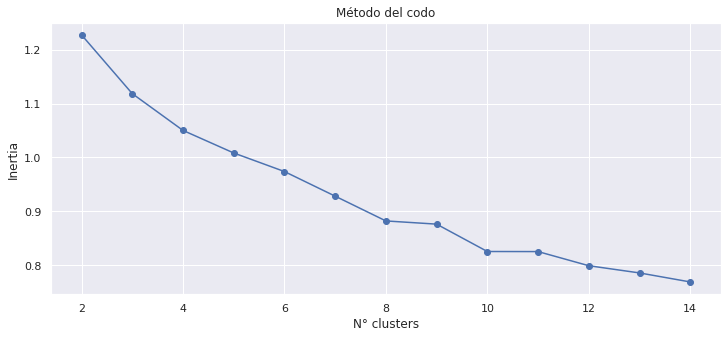

In [16]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(n_clusters, dtw_inertia_list, marker='o')
ax.set_title('Método del codo')
ax.set_xlabel('N° clusters')
ax.set_ylabel('Inertia')

plt.show()

#### GAK

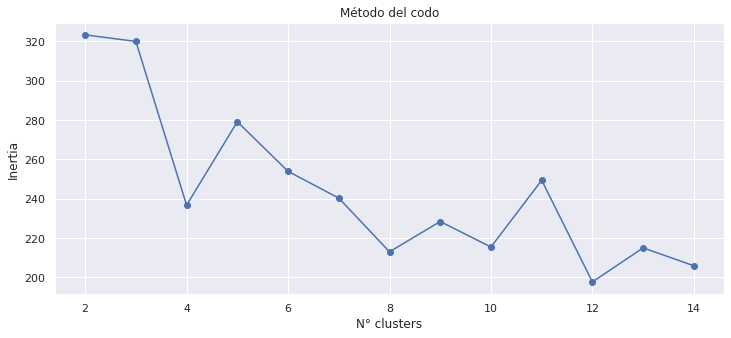

In [15]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(n_clusters, gak_inertia_list, marker='o')
ax.set_title('Método del codo')
ax.set_xlabel('N° clusters')
ax.set_ylabel('Inertia')

plt.show()

### Mejor modelo

In [152]:
seed = 42 
np.random.seed(seed)

dba_km = TimeSeriesKMeans(n_clusters=2,
                          n_init=2,
                          metric="dtw",
                          max_iter_barycenter=10,
                          random_state=seed)

_, y_pred, _ = bench_k_means(kmeans=dba_km, name="dba_minmax", data=X_train, n_clusters=2)

dba_minmax		2	5.289	1.279		0.000


### Centros de clústers

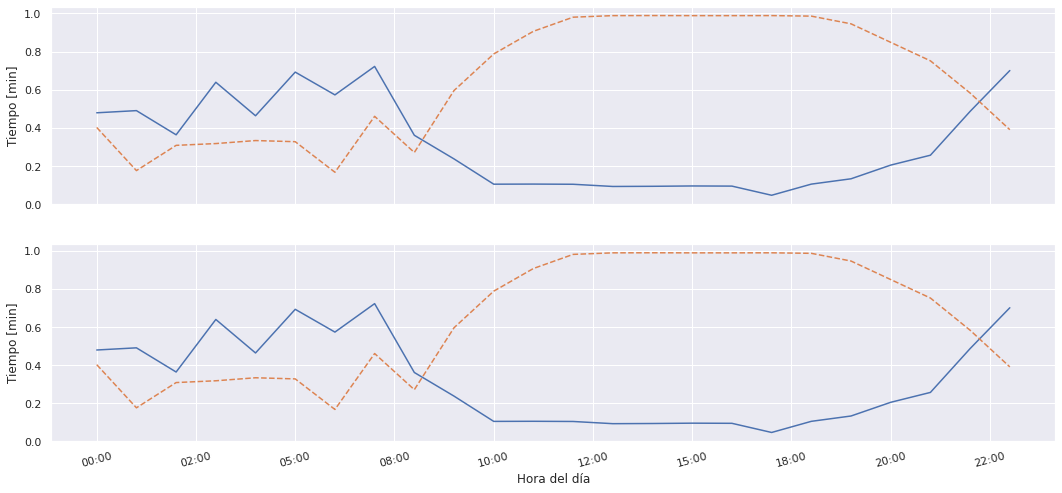

In [153]:
plot_cluster_centers(dba_km.cluster_centers_, ['asd','ewq'], "Tiempo [min]")


### Distribución de clústers

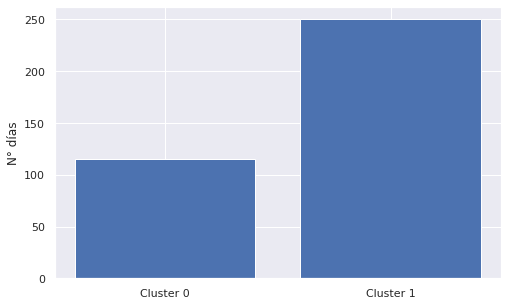

In [78]:
fig, axs = plt.subplots(figsize=(8,5))

cluster_distribution(y_pred, ax)

plt.show()

### Visualización de clústers

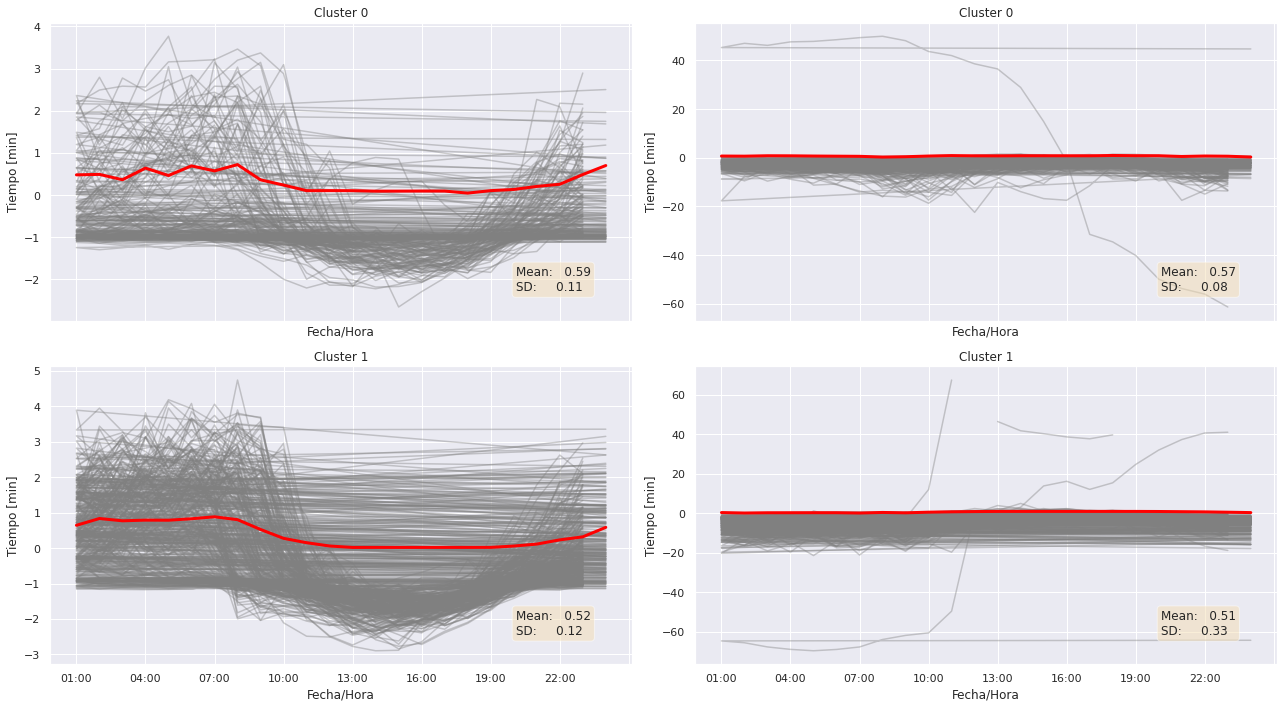

In [125]:
plot_series_by_cluster(y_pred, meteo_daily, dba_km.cluster_centers_, centers=True)

### Distribución semanal de clústers

In [25]:
weekly_cluster_distribution(y_pred, meteo_daily)

AttributeError: 'numpy.ndarray' object has no attribute 'index'